In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.models import load_model

In [2]:
BASE_DIR = 'flickr1k'
WORKING_DIR = 'flickr1k\\working'

In [3]:
# load vgg19 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [4]:
x=os.listdir('images')
len(x)

1000

In [5]:
# extract features from image
features = {}
directory = os.path.join('images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/1000 [00:00<?, ?it/s]

In [6]:

pickle.dump(features, open(os.path.join('features.pkl'), 'wb'))

In [7]:
with open(os.path.join('features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [8]:
with open(os.path.join('captions.csv'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [9]:
with open(os.path.join('captions.csv'), 'r') as f:
    next(f)
    captions_doc = f.read()
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/5001 [00:00<?, ?it/s]

In [10]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
        # take one caption at a time
            caption = captions[i]
        # preprocessing steps
        # convert to lowercase
            caption = caption.lower()
        # delete digits, special chars, etc.,
            caption = caption.replace('[^A-Za-z]', '')
        # delete additional spaces
            caption = caption.replace('\s+', ' ')
        # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
C:\Users\BalaDurga\AppData\Local\Temp\ipykernel_6584\919086354.py:12: SyntaxWarning: invalid escape sequence '\s'
  caption = caption.replace('\s+', ' ')


In [11]:
mapping['1019077836_6fc9b15408']

['A brown dog chases the water from a sprinkler on a lawn .',
 'a brown dog plays with the hose .',
 'A brown dog running on a lawn near a garden hose',
 'A dog is playing with a hose .',
 'Large brown dog running away from the sprinkler in the grass .']

In [12]:
clean(mapping)

In [13]:
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [14]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)
        all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [15]:

# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1


In [16]:
vocab_size


3216

In [17]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

32

In [18]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.96)
train = image_ids[:split]
test = image_ids[split:]

In [19]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], 	num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

In [22]:


from keras.models import Model
from keras.layers import Input, Dropout, Dense, Embedding, LSTM, add
from keras.utils import plot_model

# Define model parameters
max_length = 32 # Example value, replace with actual max_length
vocab_size = 3216 # Example value, replace with actual vocab_size

# Image feature layers
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# Sequence feature layers
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# Decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Compile the model
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Plot the model
#plot_model(model, show_shapes=True, to_file='model_plot.png')



In [23]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

30/30 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - loss: 6.5757
30/30 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - loss: 5.3778
30/30 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - loss: 4.9599
30/30 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - loss: 4.5531
30/30 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - loss: 4.1640
30/30 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - loss: 3.8463
30/30 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - loss: 3.5305
30/30 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - loss: 3.2671
30/30 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - loss: 3.0698
30/30 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - loss: 2.8795
30/30 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - loss: 2.7335
30/30 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - loss: 2.6020
30/30 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - loss: 2.4821
30/30 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - loss: 2.3750
30/30 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - loss: 2.3033
30/30 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - loss: 2.2251
30/30 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - loss: 2.1465
30/30 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - loss: 2.0698
30/30 ━━━━━━━━━━━━━━━━━━━━ 5

In [27]:
model.save('f1_model.keras')
model.save('f1_model.h5')


In [28]:
mdl=load_model("f1_model.keras")

C:\Users\BalaDurga\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [29]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [30]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [31]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()



In [32]:
for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)


  0%|          | 0/40 [00:00<?, ?it/s]

In [33]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join("images" ,image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(mdl, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq brown dog plays in deep pile of snow endseq
startseq dog looking at the camera in snow endseq
startseq dog runs through the snow endseq
startseq tan dog stand in the snow and looks up endseq
startseq the brown dog is out in the snow endseq
--------------------Predicted--------------------
startseq dog plays in the snow endseq


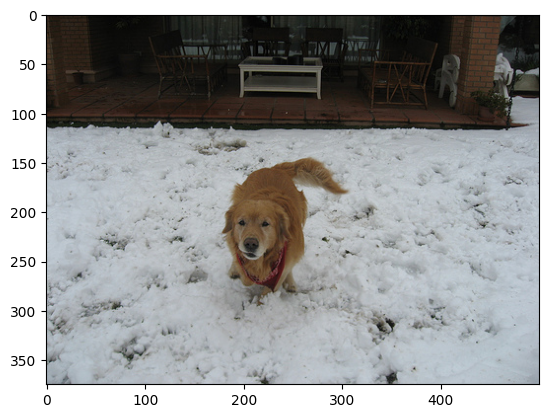

In [34]:
generate_caption('1094462889_f9966dafa6.jpg')

In [35]:
# from keras.models import load_model
vgg_model = VGG16()
# model = load_model("saved_model.h5", compile=True)
# restructure the model
vgg_model = Model(inputs=vgg_model.inputs,
                  outputs=vgg_model.layers[-2].output)

In [36]:
#image_path = 'images/1020651753_06077ec457.jpg'

image_path="images/1094462889_f9966dafa6.jpg"
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image from vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
print(feature)
text=predict_caption(mdl, feature, tokenizer, max_length)
text

[[2.7135372 0.        5.041317  ... 0.        1.8000062 0.8720414]]


'startseq dog plays in the snow endseq'

In [37]:

# Remove 'startseq' and 'endseq'
cleaned_text = text.replace("startseq", "").replace("endseq", "").strip()


In [38]:
cleaned_text

'dog plays in the snow'

In [39]:
from googletrans import Translator

# Initialize the translator
translator = Translator()

# Text to be translated
text =cleaned_text
languages = [ 'telugu','english','hindi','tamil'] 
translations = {}
for lang in languages:
    translated = translator.translate(text, dest=lang)
    translations[lang] = translated.text

# Print the translations
for lang, translation in translations.items():
    print(f"{lang}: {translation}")
    if lang=='english':
        x=translation
    elif lang=='telugu':
        y=translation

telugu: కుక్క మంచులో ఆడుతుంది
english: dog plays in the snow
hindi: कुत्ता बर्फ में खेलता है
tamil: நாய் பனியில் விளையாடுகிறது


In [40]:
import pyttsx3
engine = pyttsx3.init()

# Set properties (optional)
engine.setProperty('rate', 140)  # Speed of speech
engine.setProperty('volume', 1.0)  # Volume level (0.0 to 1.0)

# Text to be converted to speech
text = x

# Convert text to speech
engine.say(text)

# Wait for the speech to finish
engine.runAndWait()